# Bayesian Multilevel Modeling 

In [30]:
# standard imports 
import pandas as pd 
import numpy as np 

# bayesian modeling 
import pymc as pm
import xarray as xr 

# visualizations
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import arviz as az 
%matplotlib inline
style.use("fivethirtyeight")

# transformers 
from sklearn.preprocessing import OneHotEncoder

In [31]:
# reading in our dataset 

nys_gradrates_df = pd.read_csv("data/2022_nys_gradrates_compiled.csv")

In [32]:
# previewing first five rows of our dataset
nys_gradrates_df.head()

entity_cd  county        district  nrc_index              school  year  \
0  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
1  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
2  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
3  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
4  10100010034  Albany  Albany City Sd          3  Albany High School  2022   

                     subgroup  grad_rate  
0          Hispanic or Latino       73.7  
1                       White       86.9  
2                 Multiracial       77.4  
3    English Language Learner       70.4  
4  Economically Disadvantaged       75.5

In [33]:
# transforming subgroups into binary form using pd.getdummies
subgroup_enc = pd.get_dummies(nys_gradrates_df.subgroup,dtype='int64')

# concatenating our two dataframes 
nys_gradrates_df = pd.concat([nys_gradrates_df,subgroup_enc],axis=1)

# dropping the pre-encoded subgroup column
nys_gradrates_df = nys_gradrates_df.drop(columns=["subgroup"])

# shifting column order for readability
nys_gradrates_df = nys_gradrates_df[["entity_cd","county","district","nrc_index","school","year",
                  "American Indian or Alaska Native", "Asian or Native Hawaiian/Other Pacific Islander",
                  "Black or African American","Economically Disadvantaged","English Language Learner",
                  "Hispanic or Latino","Multiracial","Students with Disabilities","White","grad_rate"]]
# standardizing the percentages to be floats
nys_gradrates_df.grad_rate = nys_gradrates_df.grad_rate/100

In [34]:
nys_gradrates_df.head()

entity_cd  county        district  nrc_index              school  year  \
0  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
1  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
2  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
3  10100010034  Albany  Albany City Sd          3  Albany High School  2022   
4  10100010034  Albany  Albany City Sd          3  Albany High School  2022   

   American Indian or Alaska Native  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   Asian or Native Hawaiian/Other Pacific Islander  Black or African American  \
0                                                0                          0   
1                                                0                          0   
2                                                0                          0   
3                                                0                          0   
4                                                0                          0   

   Economically Disadvantaged  English Language Learner  Hispanic or Latino  \
0                           0                         0                   1   
1                           0                         0                   0   
2                           0                         0                   0   
3                           0                         1                   0   
4                           1                         0                   0   

   Multiracial  Students with Disabilities  White  grad_rate  
0            0                           0      0      0.737  
1            0                           0      1      0.869  
2            1                           0      0      0.774  
3            0                           0      0      0.704  
4            0                           0      0      0.755

In [35]:
# number of unique districts
len(nys_gradrates_df.district.unique())

660

In [36]:
# number of unique counties 
len(nys_gradrates_df.county.unique())

62

In [37]:
# number of unique schools
len(nys_gradrates_df.school.unique())

1240

<Axes: >

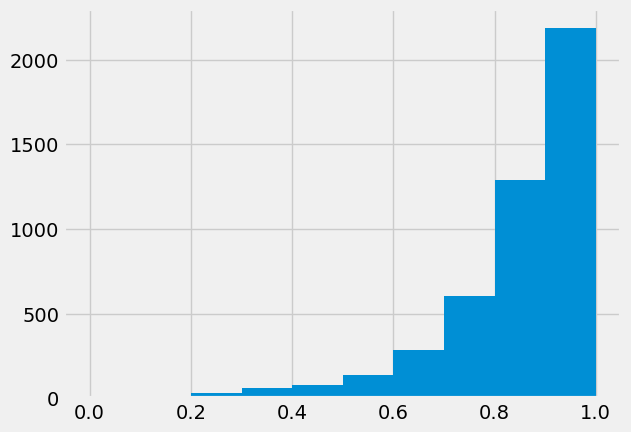

In [206]:
nys_gradrates_df.grad_rate.hist(bins=10,)

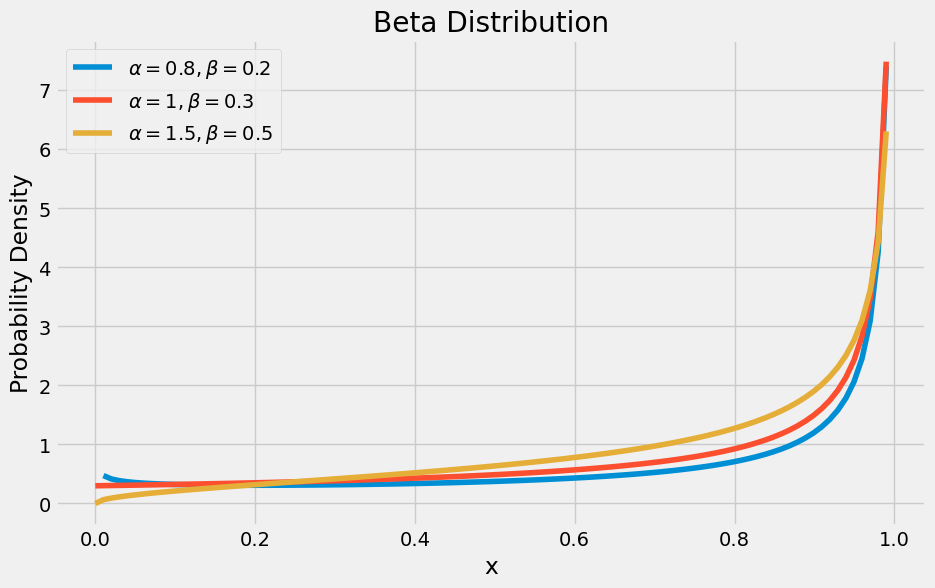

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as sp_beta

# Define the shape parameters α and β
alpha_values = [0.8, 1, 1.5]
beta_values = [0.2, .3, .5]

# Generate x values from 0 to 1 for plotting
x = np.linspace(0, 1, 100)

# Plot the Beta distributions
plt.figure(figsize=(10, 6))
for alpha, beta_param in zip(alpha_values, beta_values):
    y = sp_beta.pdf(x, alpha, beta_param)
    plt.plot(x, y, label=r'$\alpha={}, \beta={}$'.format(alpha, beta_param))

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Beta Distribution')
plt.legend()
plt.grid(True)
plt.show()

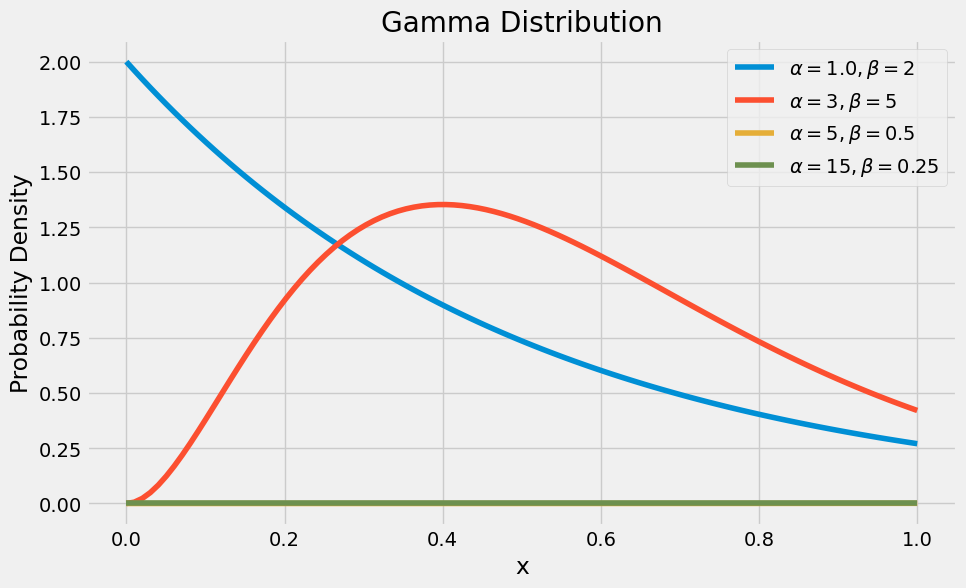

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Define shape (alpha) and scale (beta) parameters
alpha_values = [1.0, 3, 5,15]
beta_values = [2, 5, .5, .25]

# Generate x values from 0 to 20 for plotting
x = np.linspace(0, 1, 100)

# Plot the Gamma distributions
plt.figure(figsize=(10, 6))
for alpha, beta in zip(alpha_values, beta_values):
    y = gamma.pdf(x, alpha, scale=1/beta)
    plt.plot(x, y, label=r'$\alpha={}, \beta={}$'.format(alpha, beta))

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gamma Distribution')
plt.legend()
plt.grid(True)
plt.show()

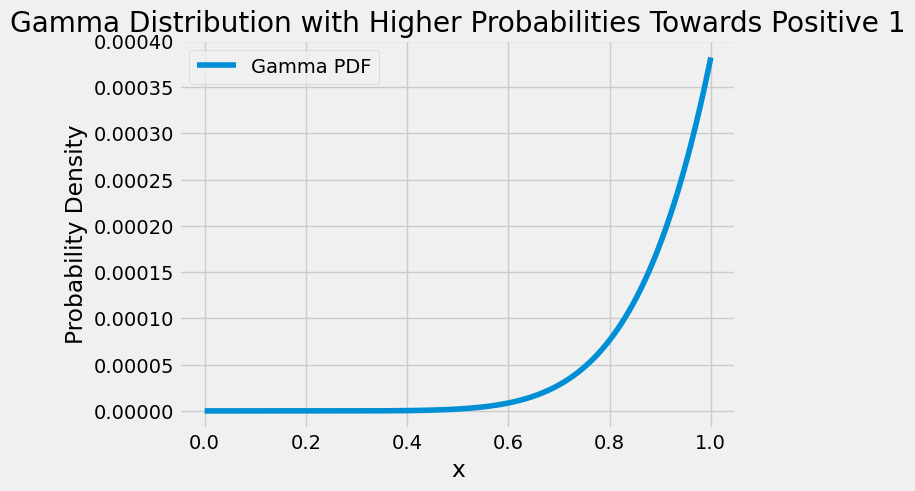

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Define parameters for the gamma distribution
shape_parameter = 10   # Choose a value for k
scale_parameter = 0.5   # Choose a value for theta

# Create a range of values for x (e.g., from 0 to 5)
x = np.linspace(0, 1, 1000)

# Compute the probability density function (PDF) for the gamma distribution
pdf = gamma.pdf(x, a=shape_parameter, scale=scale_parameter)

# Plot the PDF
plt.plot(x, pdf, label='Gamma PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gamma Distribution with Higher Probabilities Towards Positive 1')
plt.legend()
plt.show()


## Hierarchical Bayesian Modeling

To build up to a hierarchical model, we'll start off simple, trying to predict 

In [40]:
r_seed = 205

In [41]:
# creating a lookup dictionary for indexing

nys_counties = nys_gradrates_df.county.unique() # list of all unique counties 
n_counties = len(nys_counties) # 62 unique counties
county_lookup = dict(zip(nys_counties, range(n_counties))) # dictionary with county name and index 

In [43]:
# creating local copies of variables for future models 
county = nys_gradrates_df["county_code"] = nys_gradrates_df.county.replace(county_lookup).values
grad_rate = nys_gradrates_df.grad_rate # predictor var: float64

# index variables for each subgroup 
hisp_latinx = nys_gradrates_df['Hispanic or Latino'].values
ells = nys_gradrates_df['English Language Learner'].values
amer_native = nys_gradrates_df['American Indian or Alaska Native'].values
aapi = nys_gradrates_df['Asian or Native Hawaiian/Other Pacific Islander'].values
aa_blk = nys_gradrates_df['Black or African American'].values
swd = nys_gradrates_df['Students with Disabilities'].values
white = nys_gradrates_df['White'].values
multiracial = nys_gradrates_df['Multiracial'].values
econ_disadv = nys_gradrates_df['Economically Disadvantaged'].values

### Pooled Model 

For simplicity's sake, we'll build a simple model 

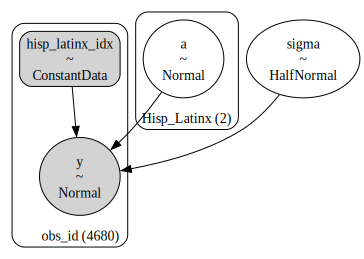

In [44]:
# setting up the dimensions of our model
coords = {"Hisp_Latinx":[0,1], "obs_id": np.arange(hisp_latinx.size)}

# building up our model 
with pm.Model(coords=coords) as pooled_model: 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latinx, dims = "obs_id")
    # setting up priors 
    a = pm.Normal("a", 80.0, sigma=5.0, dims="Hisp_Latinx")
    
    theta = a[hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y", theta, sigma=sigma, observed=grad_rate, dims="obs_id")
pm.model_to_graphviz(pooled_model)

Sampling: [a, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


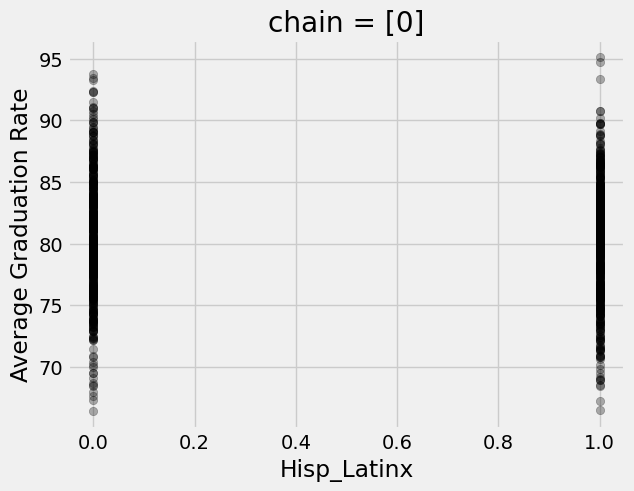

In [45]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=r_seed)
    idata_prior = prior_checks.extend(pm.sample())
    
_, ax = plt.subplots()
prior_checks.prior.plot.scatter(x='Hisp_Latinx',y="a",color="k",alpha=0.3,ax=ax)
ax.set_ylabel("Average Graduation Rate");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


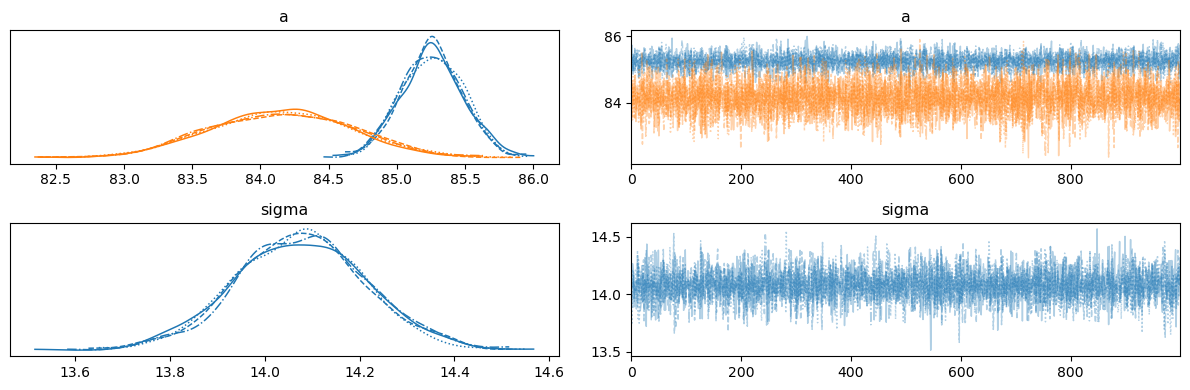

In [15]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=r_seed)
    pooled_idata = az.plot_trace(pooled_trace)
az.summary(pooled_trace)
plt.tight_layout()

### Unpooled Model 

The unpooled model ...

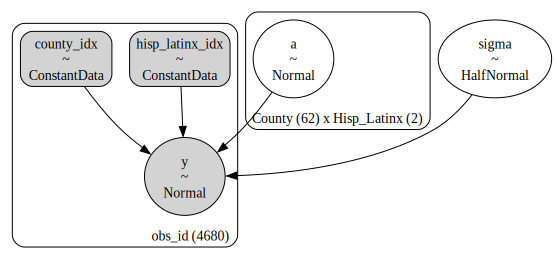

In [48]:
# updating the dimensions of our model
coords["County"] = nys_counties

# building up our unpooled model 
with pm.Model(coords=coords) as unpooled_model:
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latinx, dims = "obs_id")
    county_idx = pm.ConstantData("county_idx", county, dims="obs_id")
    # setting up our priors 
    a = pm.Normal("a", 80.0, sigma=5.0, dims=("County","Hisp_Latinx"))
    
    theta = a[county_idx,hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y",theta, sigma=sigma, observed=grad_rate,dims="obs_id")
pm.model_to_graphviz(unpooled_model)

In [49]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=r_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


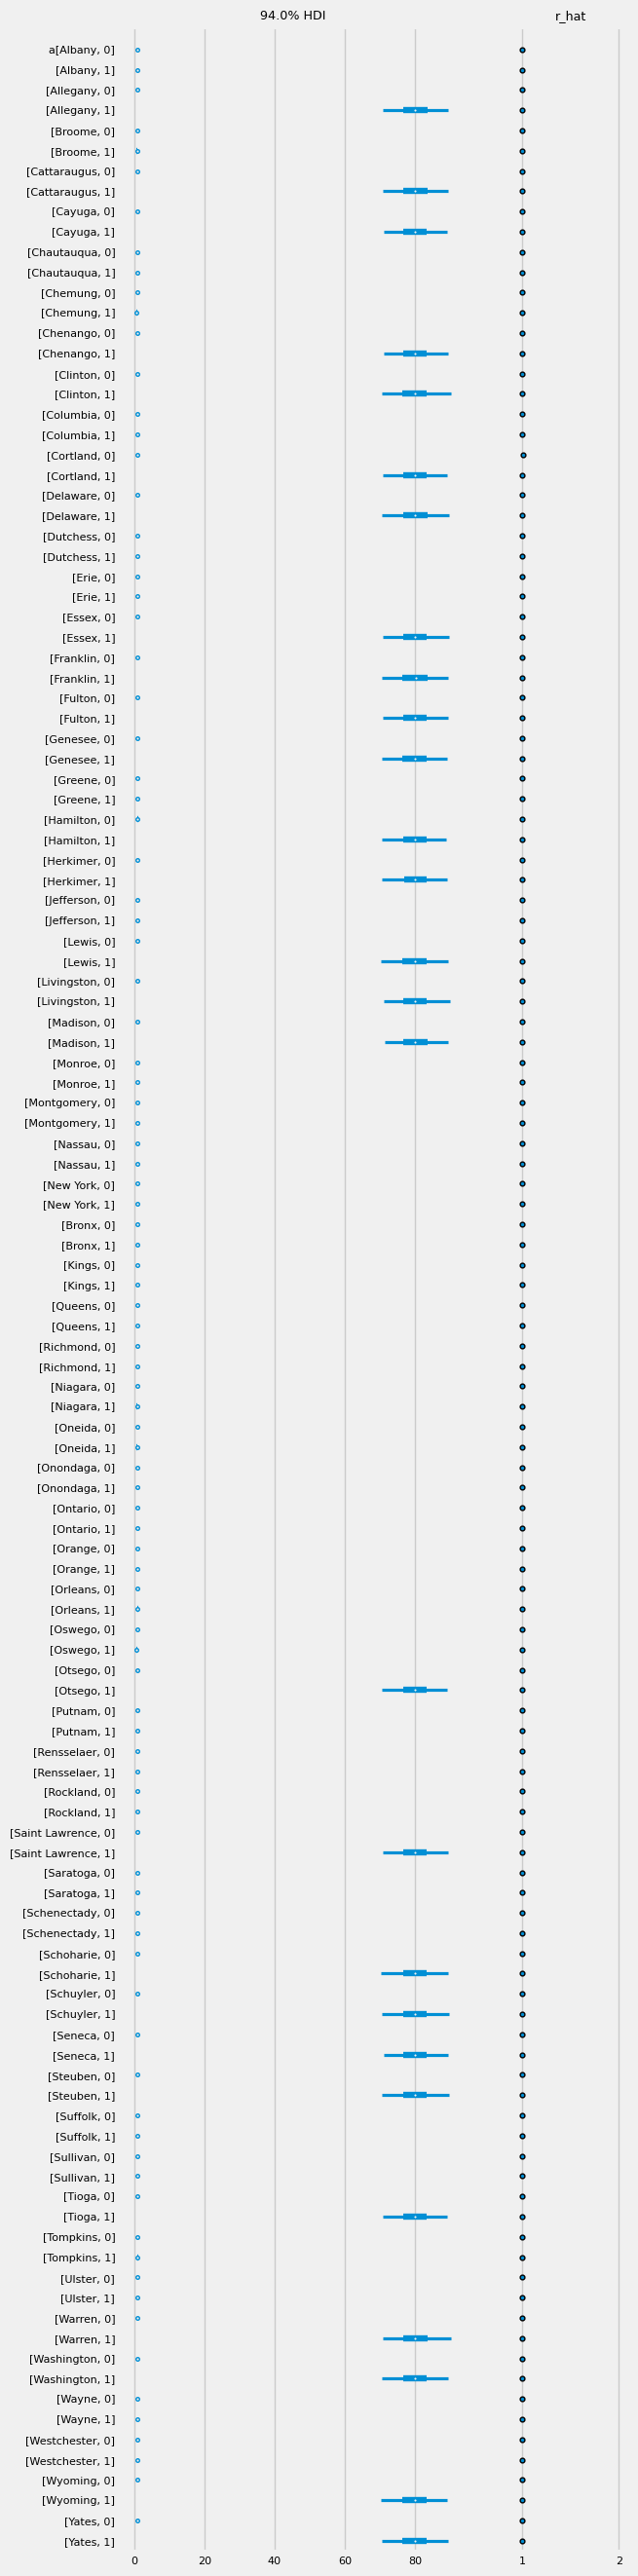

In [50]:
# expected values for effect of being Hispanic/Latinx subgroup in each county 
az.plot_forest(unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [51]:
unpooled_means = unpooled_idata.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_idata)

### Hierarchical Model 

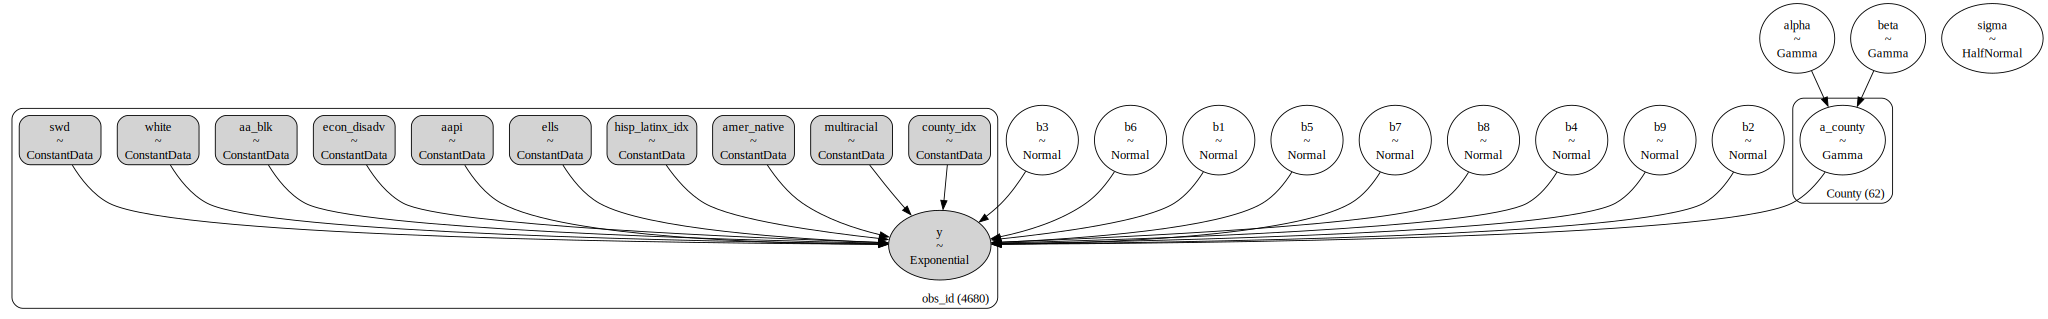

In [167]:
with pm.Model(coords=coords) as varying_intercept:
    # adding our county level index variables
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id") 
    
    # adding subgroup index variables 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx",hisp_latinx,dims="obs_id")
    ells_idx = pm.ConstantData("ells",ells, dims="obs_id")
    amer_native_idx = pm.ConstantData("amer_native",amer_native,dims="obs_id")
    aapi_idx = pm.ConstantData("aapi", aapi, dims="obs_id")
    aablk_idx = pm.ConstantData("aa_blk", aa_blk, dims="obs_id") 
    swd_idx = pm.ConstantData("swd",swd, dims="obs_id")
    white_idx = pm.ConstantData("white", white, dims="obs_id")
    multiracial_idx = pm.ConstantData("multiracial", multiracial, dims="obs_id")
    econ_disadv_idx = pm.ConstantData("econ_disadv", econ_disadv, dims="obs_id")
    
    # hyperpriors 
    alpha = pm.Gamma('alpha', alpha = 10, beta = .5)
    beta = pm.Gamma('beta', alpha = 1, beta = .1)
    
    # varying intercepts 
    a_county = pm.Gamma("a_county", alpha, beta, dims="County")
    # common slopes 
    b1 = pm.Normal("b1",mu=0.8, sigma=0.2)
    b2 = pm.Normal("b2",mu=0.8, sigma=0.2)
    b3 = pm.Normal("b3",mu=0.8, sigma=0.2)
    b4 = pm.Normal("b4",mu=0.8, sigma=0.2)
    b5 = pm.Normal("b5",mu=0.8, sigma=0.2)
    b6 = pm.Normal("b6",mu=0.8, sigma=0.2)
    b7 = pm.Normal("b7",mu=0.8, sigma=0.2)
    b8 = pm.Normal("b8",mu=0.8, sigma=0.2)
    b9 = pm.Normal("b9",mu=0.8, sigma=0.2)
    
    # expected values per county: 
    theta = a_county[county_idx] + (b1 * hisp_latinx_idx) + (b2 * ells_idx) + (b3 * amer_native_idx) + (b4 * aapi_idx) +(b5 * aablk_idx) + (b6 * swd_idx) + (b7 * white_idx) + (b8 * multiracial_idx) + (b9 * econ_disadv_idx)
    # model error 
    sigma = pm.HalfNormal("sigma", 1.0)
    
    # likelihood function
    y = pm.Exponential("y",lam=theta,observed=grad_rate,dims="obs_id")
    
pm.model_to_graphviz(varying_intercept)

In [54]:
y

y ~ Exponential(f(b9, b8, b7, b6, b5, b4, b3, b2, a_county, b1))

In [131]:
alpha

alpha ~ Gamma(5, f())

In [133]:
beta

beta ~ Gamma(1, f())

In [132]:
b1

b1 ~ Normal(0.8, 0.2)

In [174]:
# run_time = ~10 minutes?
with varying_intercept:
    varying_intercept_idata = pm.sample(
        draws=4000,tune=3000, init="adapt_diag", random_seed=r_seed, target_accept=.995,cores=3,chains=4,
        return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [alpha, beta, a_county, b1, b2, b3, b4, b5, b6, b7, b8, b9, sigma]


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 1606 seconds.


In [176]:
az.summary(varying_intercept_idata, var_names=["alpha","b1","b2","b3","b4","b5","b6","b7","b8","b9"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  18.69  4.97    9.37    27.73       0.15     0.11    993.68   2660.71   
b1      0.87  0.08    0.72     1.01       0.00     0.00    550.76   1360.06   
b2      1.05  0.09    0.88     1.23       0.00     0.00   1019.10   2932.51   
b3      0.84  0.17    0.51     1.14       0.00     0.00  15392.17  12010.71   
b4      0.75  0.08    0.59     0.90       0.00     0.00    775.73   2267.57   
b5      0.84  0.08    0.70     0.99       0.00     0.00    572.77   1423.41   
b6      0.95  0.08    0.81     1.10       0.00     0.00    575.43   1237.25   
b7      0.76  0.07    0.63     0.90       0.00     0.00    508.88   1220.43   
b8      0.81  0.13    0.58     1.06       0.00     0.00   3039.90   7444.20   
b9      0.85  0.07    0.72     0.99       0.00     0.00    486.54   1083.03   

       r_hat  
alpha   1.00  
b1      1.01  
b2      1.00  
b3      1.00  
b4      1.00  
b5      1.01  
b6      1.01  
b7      1.01  
b8      1.00  
b9      1.01

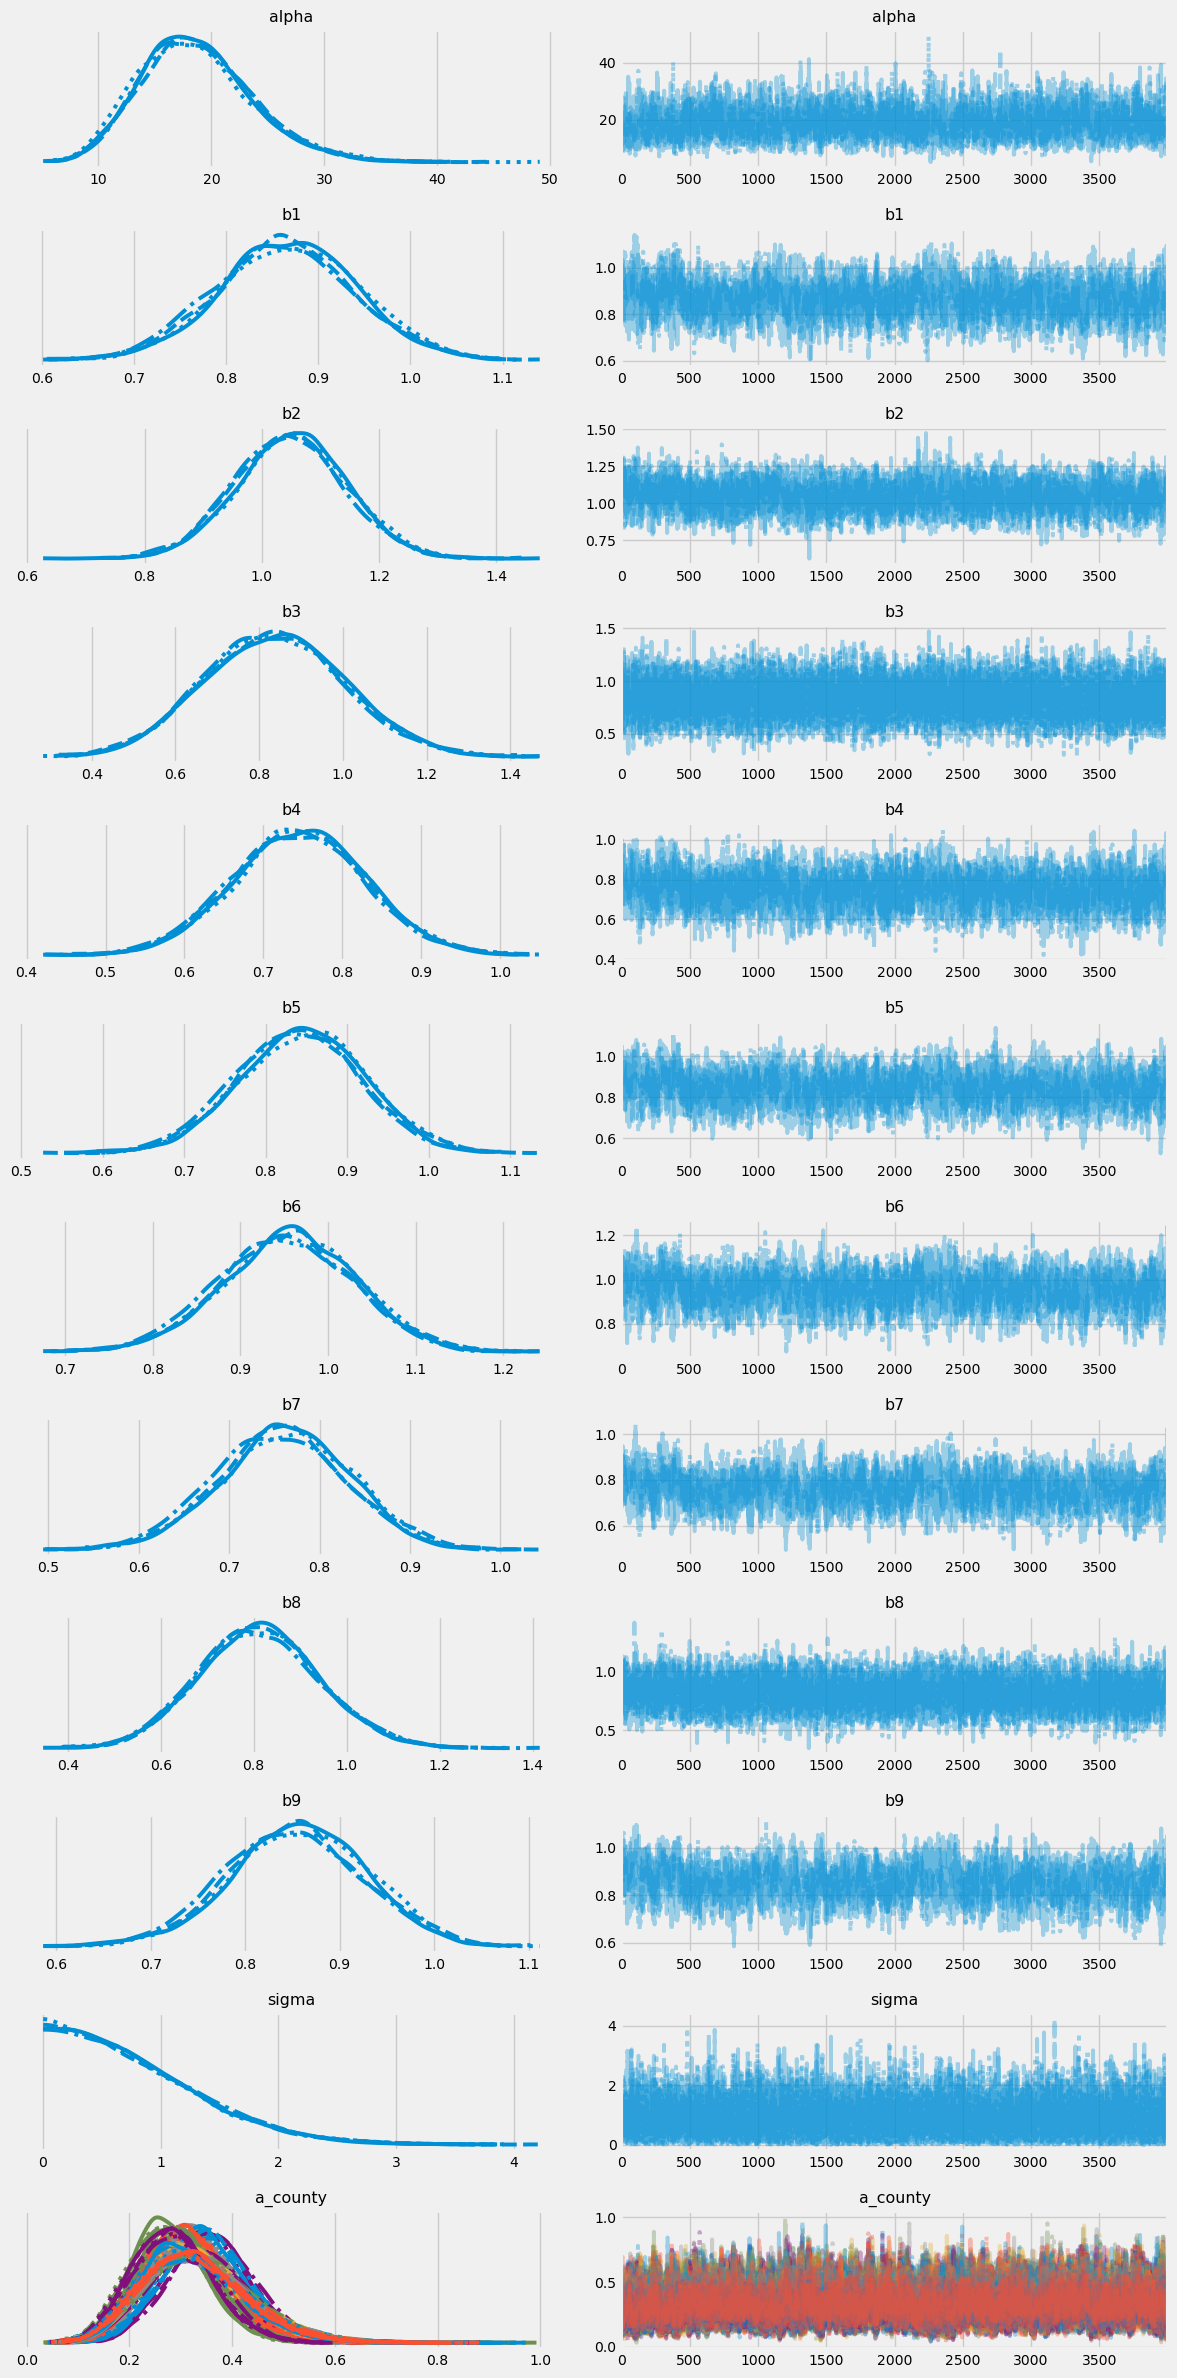

In [177]:
az.plot_trace(varying_intercept_idata,var_names=["alpha","b1","b2","b3","b4","b5","b6","b7","b8","b9","sigma","a_county"])
plt.tight_layout()

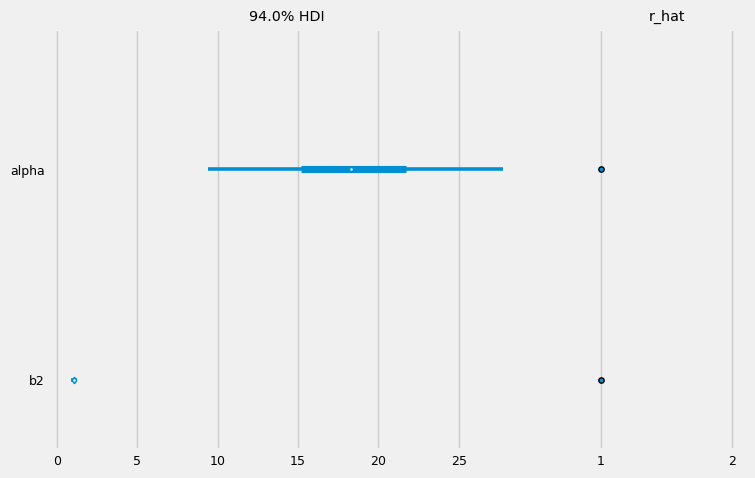

In [186]:
az.plot_forest(
    varying_intercept_idata, var_names=["alpha", "b2"], r_hat=True, combined=True, textsize=9
);

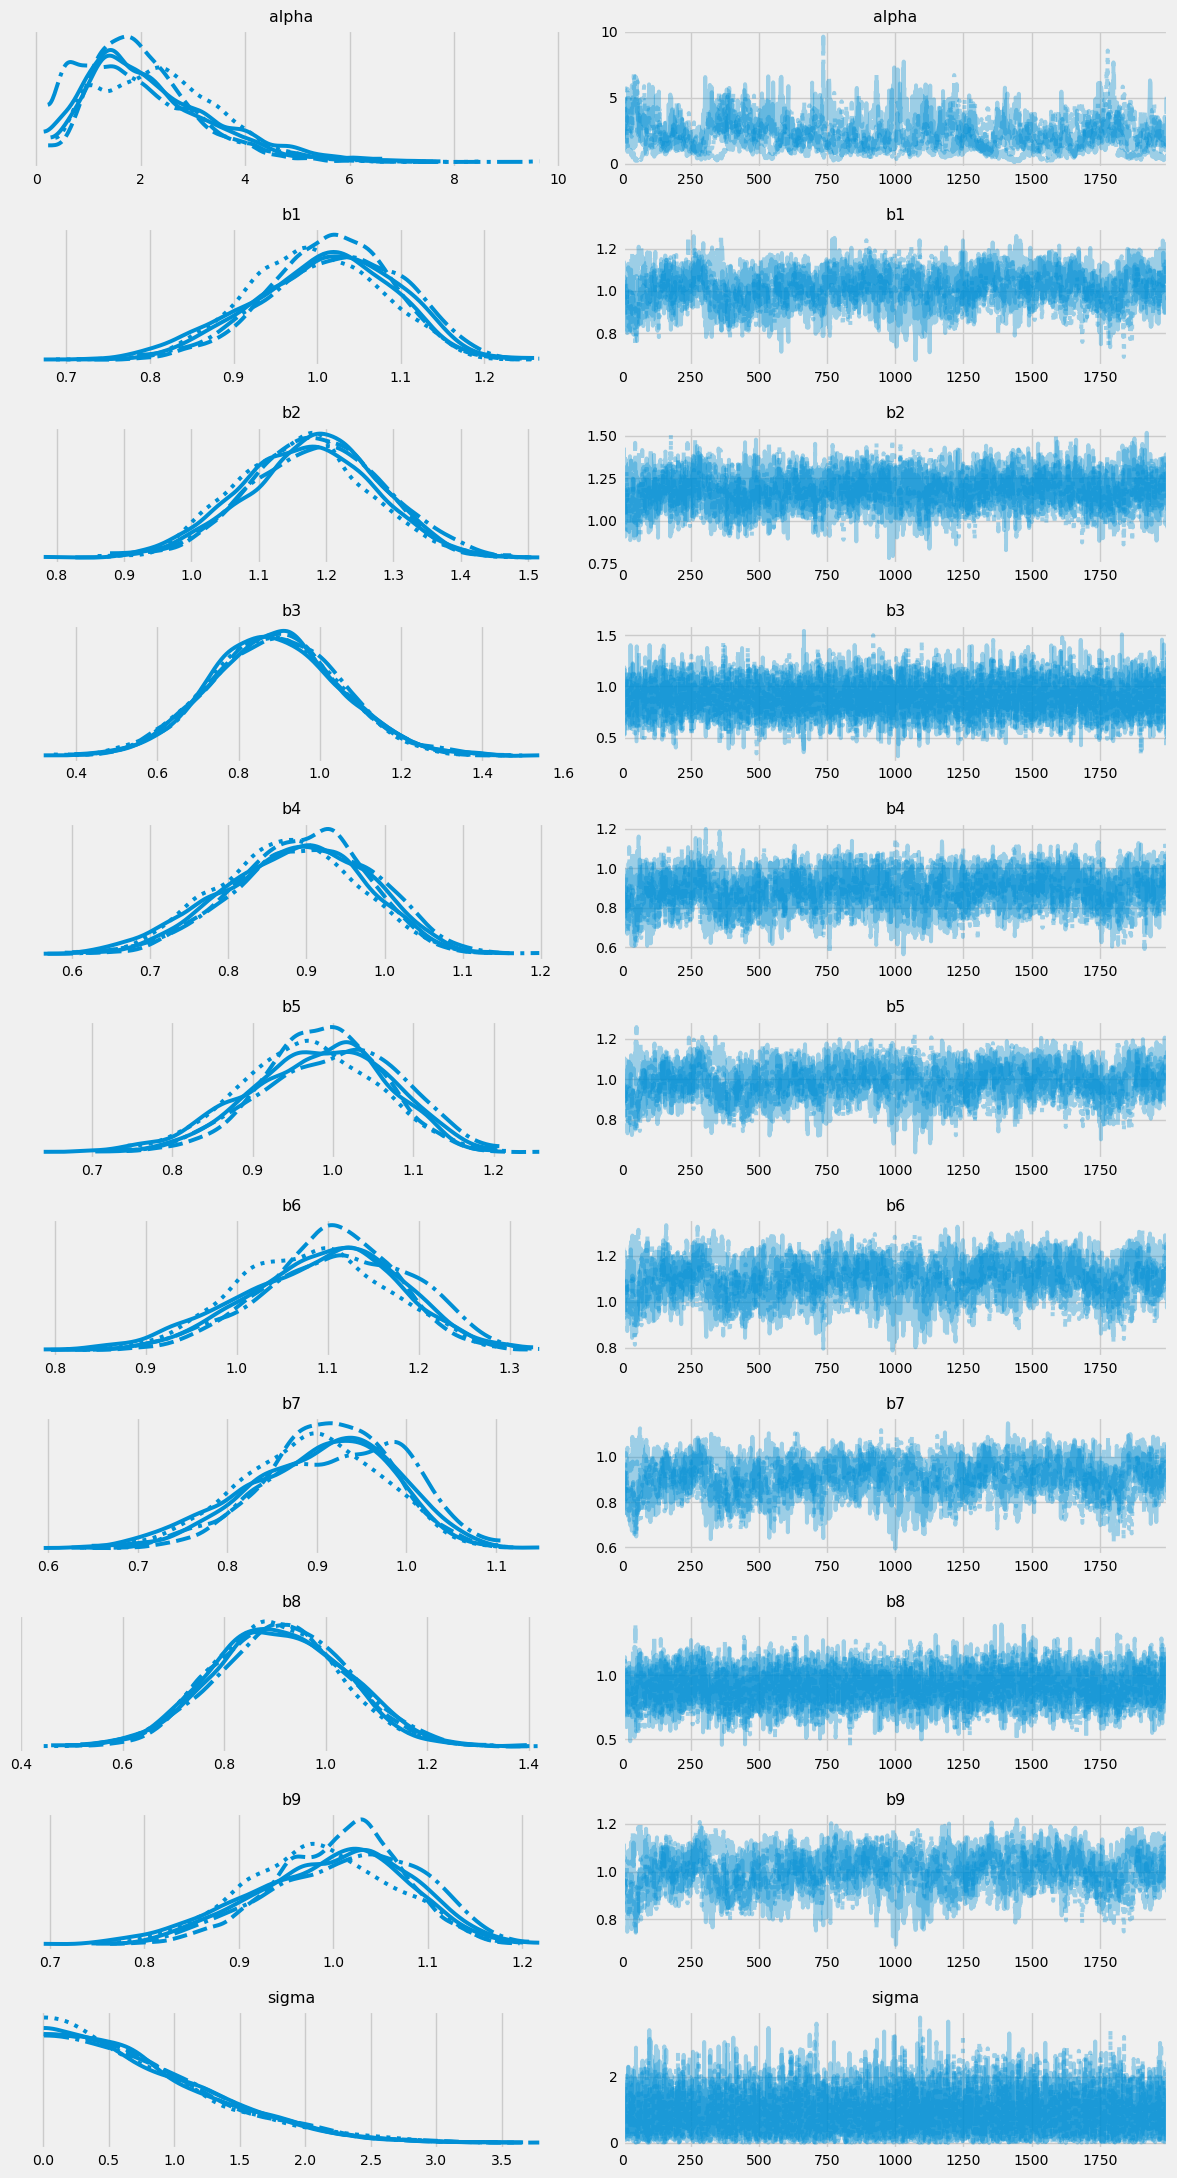

In [164]:
az.plot_trace(varying_intercept_idata, var_names=["alpha","b1","b2","b3","b4","b5","b6","b7",
                                                  "b8","b9", "sigma"])
plt.tight_layout()
plt.show()

In [187]:
# summary of coefficients
az.summary(varying_intercept_idata, var_names=["alpha","b1","b2","b3","b4","b5","b6","b7",
                                               "b8","b9", "sigma"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  18.69  4.97    9.37    27.73       0.15     0.11    993.68   2660.71   
b1      0.87  0.08    0.72     1.01       0.00     0.00    550.76   1360.06   
b2      1.05  0.09    0.88     1.23       0.00     0.00   1019.10   2932.51   
b3      0.84  0.17    0.51     1.14       0.00     0.00  15392.17  12010.71   
b4      0.75  0.08    0.59     0.90       0.00     0.00    775.73   2267.57   
b5      0.84  0.08    0.70     0.99       0.00     0.00    572.77   1423.41   
b6      0.95  0.08    0.81     1.10       0.00     0.00    575.43   1237.25   
b7      0.76  0.07    0.63     0.90       0.00     0.00    508.88   1220.43   
b8      0.81  0.13    0.58     1.06       0.00     0.00   3039.90   7444.20   
b9      0.85  0.07    0.72     0.99       0.00     0.00    486.54   1083.03   
sigma   0.79  0.60    0.00     1.87       0.00     0.00   9443.33   5464.23   

       r_hat  
alpha   1.00  
b1      1.01  
b2      1.00  
b3      1.00  
b4      1.00  
b5      1.01  
b6      1.01  
b7      1.01  
b8      1.00  
b9      1.01  
sigma   1.00

After running our model, some key `beta` coefficients are `b2`, `b4`, `b6`, `b7`. These coefficients correspond to the effects of student subgroup, namely, `English Language Learner`, `Asian American or Native Hawaiian`, `Students with Disabilities`, `White`. **This can be interpreted as follows:**


After accounting for the variation in county: 
- Students that are `English Language Learners` have a 13% lower graduation rate compared to other students. 
- Students that are `Asian American or Native Hawaiian` have a 9.67% higher graduation rate compared to other students.
- `Students with Disabilities` have a 6% lower graduation rate compared to other students.
- `White` students have an ~ 8% higher graduation rate compared to to other students.

**Note:** This is only the relative effect of students belonging to one subgroup on graduation rates. 

### Visualizing Subgroup Effect

In order to visualize the effects of belonging to the aforementioned subgroup, we'll visualize the expected graduation rate for each county and the effect of subgroup. The following graphs **do not** take into account uncertainty for each county.

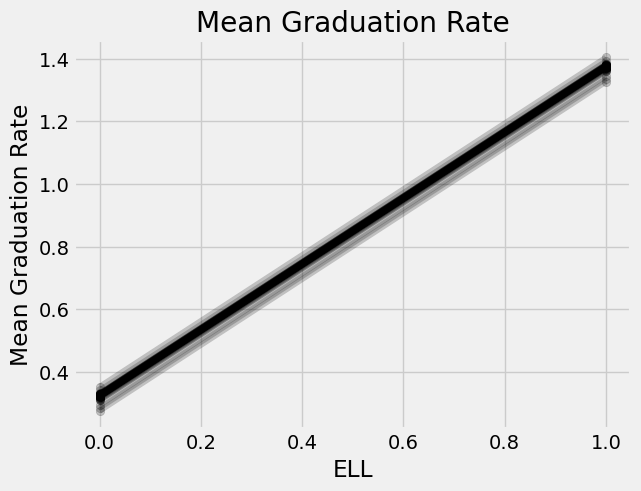

In [188]:
xvals = xr.DataArray([0, 1], dims="ELL", coords={"ELL": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b2 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="ELL", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate");

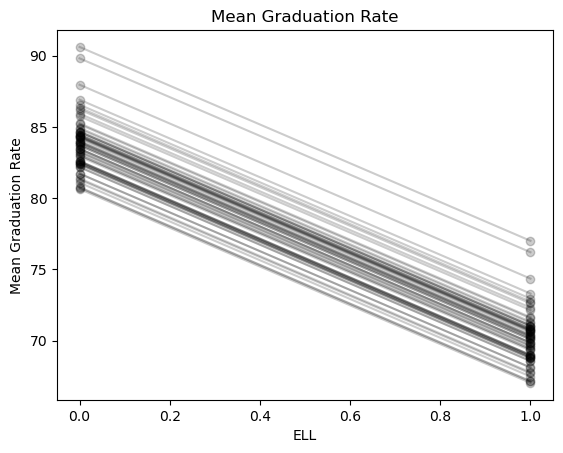

In [25]:
xvals = xr.DataArray([0, 1], dims="ELL", coords={"ELL": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b2 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="ELL", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate");

We can see that the effect of being an English Language Learner produces a lower average graduation rate ~ 72% compared to ~ 83%. 

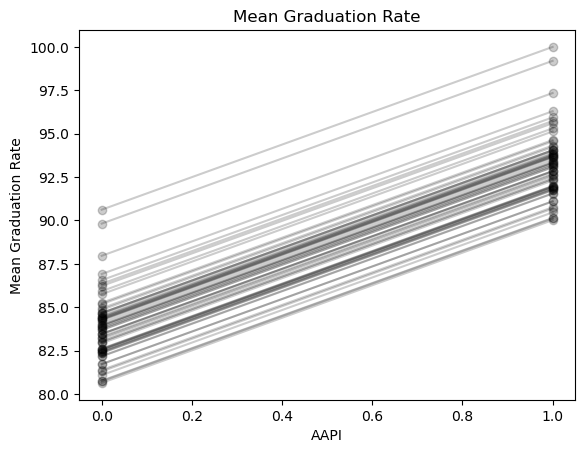

In [26]:
xvals = xr.DataArray([0, 1], dims="AAPI", coords={"AAPI": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b4 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="AAPI", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate");

We can see that the effect of being `Asian American or Native Hawaiian` produces a higher average graduation rate ~ 92.5% compared to ~ 83%. 

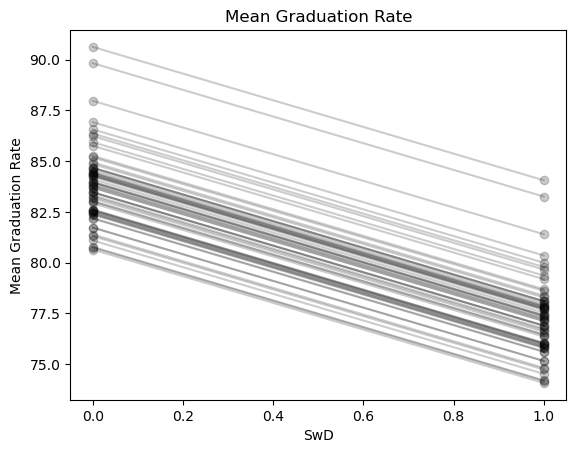

In [27]:
xvals = xr.DataArray([0, 1], dims="SwD", coords={"SwD": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b6 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="SwD", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate");

We can see that the effect of being a `Student with Disability` produces a lower average graduation rate ~ 77% compared to ~ 84%. 

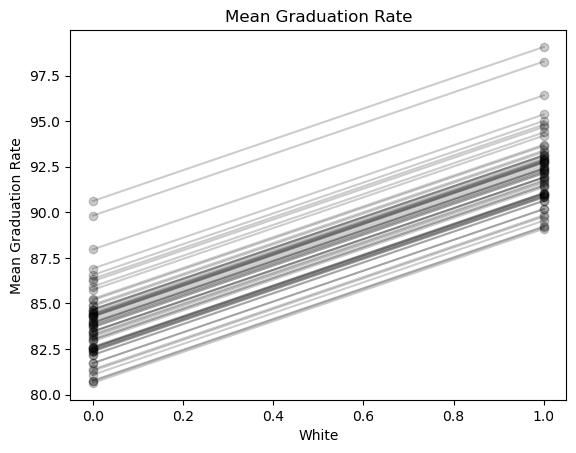

In [28]:
xvals = xr.DataArray([0, 1], dims="White", coords={"White": [0,1]})
post = varying_intercept_idata.posterior  # alias for readability
theta = (
    (post.a_county + post.b7 * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Graduation Rate")
)

_, ax = plt.subplots()
theta.plot.scatter(x="White", y="Mean Graduation Rate", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Graduation Rate"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("Mean Graduation Rate");

We can see that the effect of being `White` produces a higher average graduation rate ~ 92.5% compared to ~ 83%. 

### Posterior Predictive Checks

In [179]:
with varying_intercept:
    ppc = pm.sample_posterior_predictive(varying_intercept_idata,var_names=["alpha","beta","y"])

Sampling: [a_county, alpha, beta, y]


In [181]:
#ppc

Maybe try a different distribution family -- LogNormal?

In [142]:
#with varying_intercept:
#    ppc = pm.sample_posterior_predictive(trace,model=varying_intercept,var_names=["alpha","beta","y"])

In [140]:
ppc.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 5, draw: 2000, obs_id: 4680)
Coordinates:
  * chain    (chain) int32 0 1 2 3 4
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 ... 4673 4674 4675 4676 4677 4678 4679
Data variables:
    y        (chain, draw, obs_id) float64 3.348 1.8 0.09687 ... 0.4508 1.294
Attributes:
    created_at:                 2023-08-01T15:59:17.540066
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1

In [89]:
ppc.posterior_predictive.y[0].shape

(3000, 4680)

In [152]:
az.plot_ppc(posterior_predictive=ppc, model=varying_intercept)

TypeError: plot_ppc() got an unexpected keyword argument 'posterior_predictive'

<Axes: xlabel='y / y'>

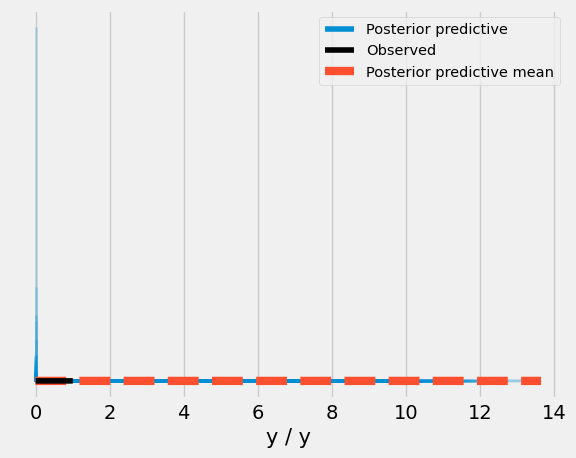

In [184]:
az.plot_ppc(ppc)

In [151]:
az.summary(ppc)

C:\Users\Kevin\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        80.008  5.039  70.513   89.496      0.025    0.018   40361.0   
sigma_a   0.794  0.600   0.000    1.863      0.003    0.002   40087.0   
b1       -0.011  5.011  -9.450    9.435      0.025    0.018   39217.0   
b2       -0.013  4.996  -9.161    9.639      0.025    0.018   40187.0   
b3        0.025  4.994  -9.341    9.466      0.025    0.018   40738.0   
b4        0.014  5.041  -9.348    9.616      0.025    0.018   40214.0   
b5        0.024  5.016  -9.529    9.337      0.025    0.018   39864.0   
b6        0.022  4.987  -9.320    9.408      0.025    0.018   39819.0   
b7        0.036  5.013  -9.687    9.174      0.026    0.018   37702.0   
b8        0.004  4.998  -9.179    9.583      0.025    0.018   39439.0   
b9       -0.001  4.954  -9.271    9.310      0.025    0.018   40122.0   
sigma     0.803  0.604   0.000    1.881      0.003    0.002   40496.0   

         ess_tail  r_hat  
a         39712.0    1.0  
sigma_a   39372.0    1.0  
b1        39131.0    1.0  
b2        38659.0    1.0  
b3        39053.0    1.0  
b4        39678.0    1.0  
b5        40098.0    1.0  
b6        39365.0    1.0  
b7        38503.0    1.0  
b8        39834.0    1.0  
b9        39839.0    1.0  
sigma     39640.0    1.0

In [37]:
with varying_intercept:
    predictions = pm.sample_posterior_predictive(varying_intercept_idata,s,var_names=["a", "sigma_a", "b1","b2","b3","b4","b5","b6","b7",
                                               "b8","b9", "sigma"])

Sampling: [a, b1, b2, b3, b4, b5, b6, b7, b8, b9, sigma, sigma_a]


In [83]:
varying_intercept_idata["observed_data"]["y"].values

array([73.7, 86.9, 77.4, ..., 88.6, 78.6, 68.8])

In [86]:
predictions

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [87]:
predictions

<xarray.Dataset>
Dimensions:  (obs_id: 4680)
Coordinates:
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 ... 4673 4674 4675 4676 4677 4678 4679
Data variables:
    y        (obs_id) float64 73.7 86.9 77.4 70.4 75.5 ... 91.1 88.6 78.6 68.8
Attributes:
    created_at:                 2023-07-31T15:42:16.802804
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1

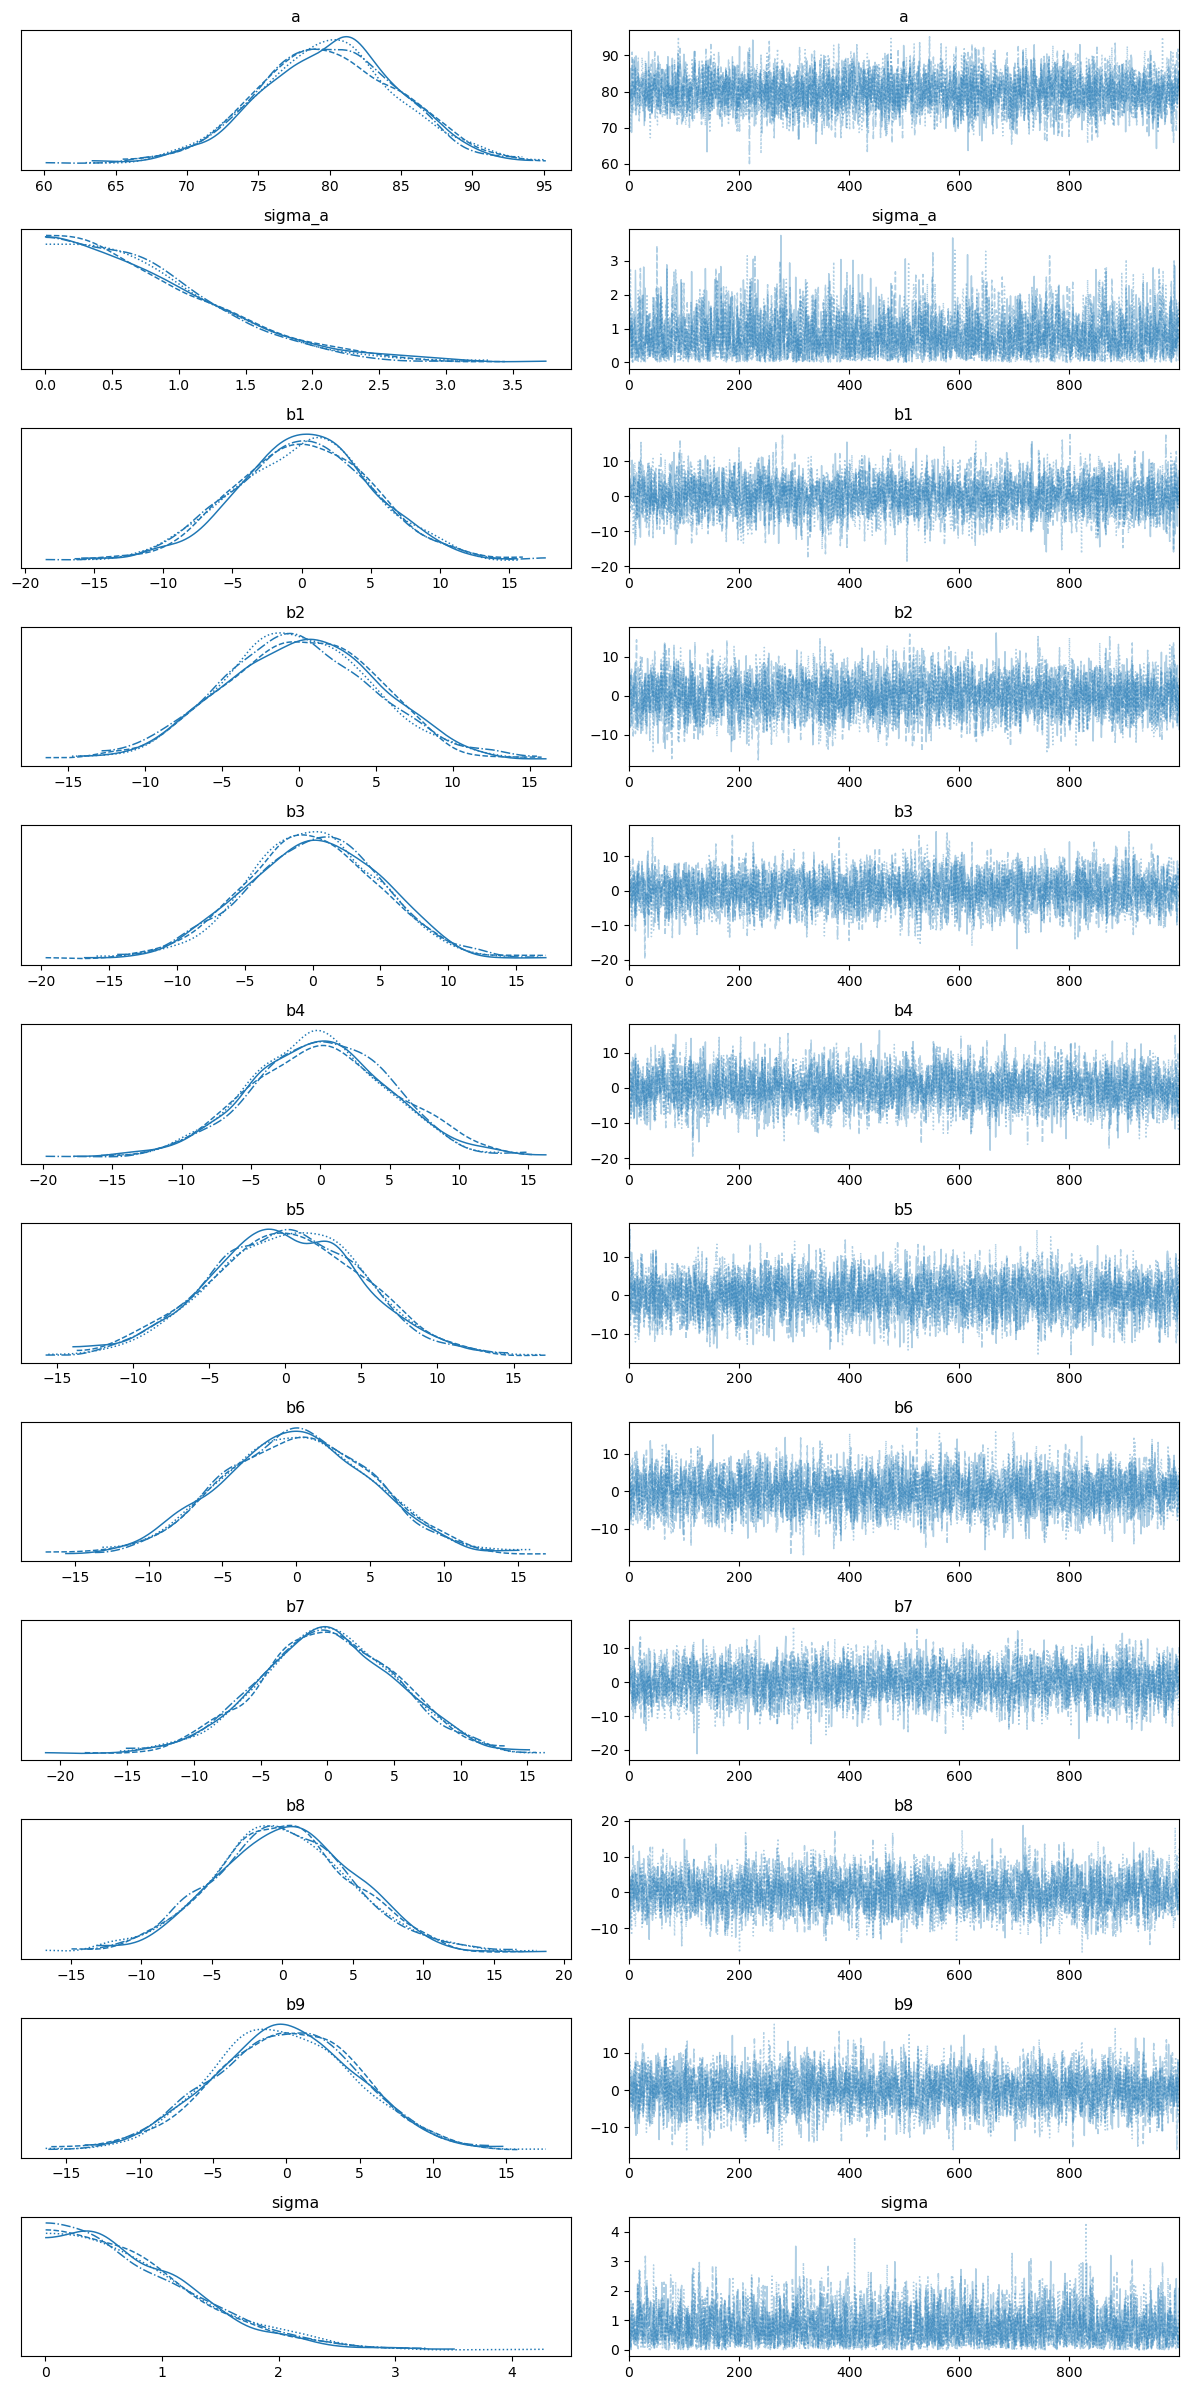

In [65]:
az.plot_trace(predictions.posterior_predictive)
plt.tight_layout()

Sampling: [alpha]
Sampling: [beta]


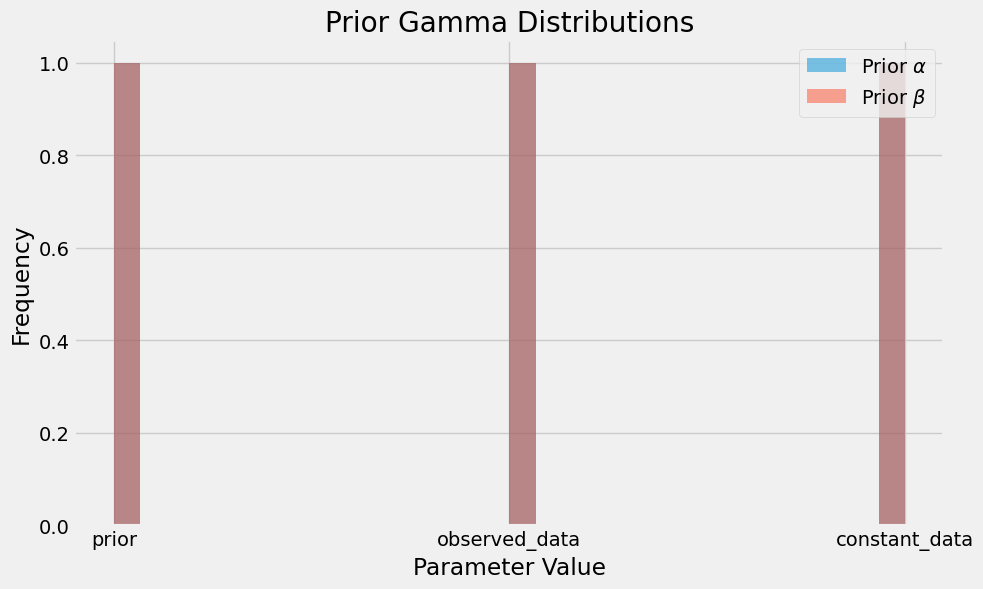

In [170]:
with varying_intercept:
    alpha_samples = pm.sample_prior_predictive(samples=5000,model=varying_intercept,var_names=["alpha"])
    beta_samples = pm.sample_prior_predictive(samples=5000,model=varying_intercept,var_names=["beta"])

# Step 3: Visualize the prior gamma distributions
plt.figure(figsize=(10, 6))
plt.hist(alpha_samples, bins=30, alpha=0.5, label=r'Prior $\alpha$')
plt.hist(beta_samples, bins=30, alpha=0.5, label=r'Prior $\beta$')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Prior Gamma Distributions')
plt.legend()
plt.show()

In [160]:
varying_intercept["alpha"]

alpha ~ Gamma(5, f())

## Hierarchical Modeling (Gaussian Prior) 

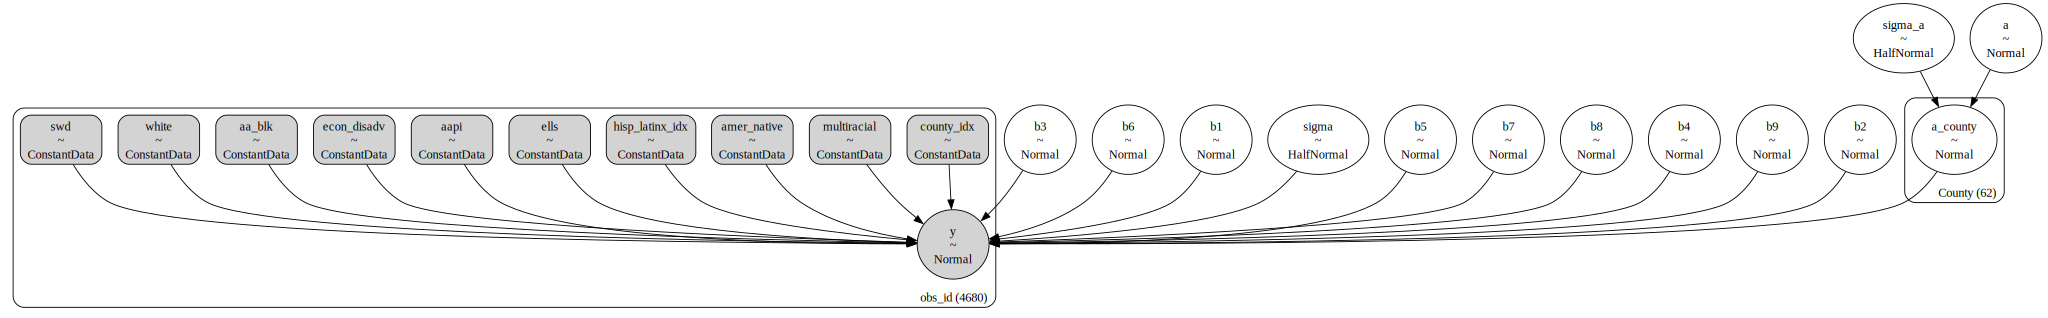

In [242]:
with pm.Model(coords=coords) as varying_intercept_2:
    # adding our county level index variables
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id") 
    
    # adding subgroup index variables 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx",hisp_latinx,dims="obs_id")
    ells_idx = pm.ConstantData("ells",ells, dims="obs_id")
    amer_native_idx = pm.ConstantData("amer_native",amer_native,dims="obs_id")
    aapi_idx = pm.ConstantData("aapi", aapi, dims="obs_id")
    aablk_idx = pm.ConstantData("aa_blk", aa_blk, dims="obs_id") 
    swd_idx = pm.ConstantData("swd",swd, dims="obs_id")
    white_idx = pm.ConstantData("white", white, dims="obs_id")
    multiracial_idx = pm.ConstantData("multiracial", multiracial, dims="obs_id")
    econ_disadv_idx = pm.ConstantData("econ_disadv", econ_disadv, dims="obs_id")
    
    # hyperpriors 
    alpha = pm.Normal("a", mu=0.85, sigma=0.1)
    sigma_a = pm.HalfNormal("sigma_a", 1.0)
    
    # varying intercepts 
    a_county = pm.Normal("a_county", mu=alpha, sigma=sigma_a, dims="County")
    
    # common slopes 
    b1 = pm.Normal("b1",mu=1, sigma=0.5)
    b2 = pm.Normal("b2",mu=1, sigma=0.5)
    b3 = pm.Normal("b3",mu=1, sigma=0.5)
    b4 = pm.Normal("b4",mu=1, sigma=0.5)
    b5 = pm.Normal("b5",mu=1, sigma=0.5)
    b6 = pm.Normal("b6",mu=1, sigma=0.5)
    b7 = pm.Normal("b7",mu=1, sigma=0.5)
    b8 = pm.Normal("b8",mu=1, sigma=0.5)
    b9 = pm.Normal("b9",mu=1, sigma=0.5)
    
    # expected values per county: 
    theta = a_county[county_idx] + (b1 * hisp_latinx_idx) + (b2 * ells_idx) + (b3 * amer_native_idx) + (b4 * aapi_idx) +(b5 * aablk_idx) + (b6 * swd_idx) + (b7 * white_idx) + (b8 * multiracial_idx) + (b9 * econ_disadv_idx)
    
    # model error 
    sigma = pm.HalfNormal("sigma", 1.0)
    
    # likelihood function
    y = pm.Normal("y", theta, sigma=sigma, observed=grad_rate, dims="obs_id")
pm.model_to_graphviz(varying_intercept_2)

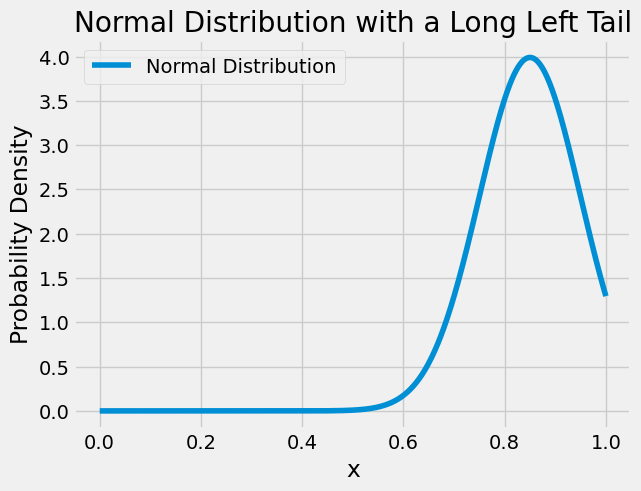

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mu = 0.85   # Mean (shifts the distribution left)
sigma = .1 # Standard deviation (controls the spread)

# Generate data points from the normal distribution
x = np.linspace(0, 1, 1000)  # Range of x values
y = norm.pdf(x, mu, sigma)    # Probability density function (PDF)

# Plot the normal distribution
plt.plot(x, y, label='Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Normal Distribution with a Long Left Tail')
plt.legend()
plt.grid(True)
plt.show()


In [244]:
with varying_intercept_2:
    varying_intercept_trace = pm.sample(draws=4000,
        tune=3500, init="adapt_diag",random_seed=r_seed, target_accept=.995, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_county, b1, b2, b3, b4, b5, b6, b7, b8, b9, sigma]


Sampling 4 chains for 2_500 tune and 4_000 draw iterations (10_000 + 16_000 draws total) took 627 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
